# The $K$-means clustering algorithm

<small><i>This notebook is a modified version of the one created by [Jake Vanderplas](https://github.com/jakevdp) for PyCon 2015. 

Source and license info of the original notebook are on [GitHub](https://github.com/jakevdp/sklearn_pycon2015/).</i></small>

In [14]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from scipy.spatial.distance import cdist
from fig_code import plot_kmeans_interactive
from sklearn.datasets.samples_generator import make_blobs
from sklearn.datasets import load_digits
from sklearn.datasets import load_sample_image
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans

# use seaborn plotting defaults
import seaborn as sns; sns.set()

## 1. Clustering algorithms

Clustering algorithms try to split a set of data points $\mathcal{S} = \{{\bf x}^{(0)},\ldots,{\bf x}^{(N-1)}\}$, into mutually exclusive clusters or groups, $\mathcal{G}_0,\ldots, \mathcal{G}_{K-1}$, such that every sample in $\mathcal{S}$ is assigned to one and only one group.

Clustering algorithms belong to the more general family of **unsupervised methods**: clusters are constructed using the data attributes alone. No labels or target values are used. This makes the difference between a clustering algorithm and a *supervised* classification algorithm.

There is not a unique formal definition of the clustering problem. Different algorithms group data into clusters following different criteria. The appropriate choice of the clustering algorithm may depend on the particular application scenario.

The image below, taken from the scikit-learn site, shows that different algorithms follow different grouping criteria, clustering the same datasets in different forms.

<img src="http://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_001.png" width=800>


In any case, all clustering algorithms share a set of common characteristics. A clustering algorithm makes use of some distance or similarity measure between data points to group data in such a way that:

* Points in some cluster should lie close to each other
* Points in different clusters should be far away
* Clusters should be separated by regions of low density of points
* Clusters may preserve some kind of *connectivity*
* Clusters may get represented by a representative or centroid
   


## 2. The $K$-means algorithm

$K$-Means is a proximity-based clustering algorithm. It searches for cluster centers or **centroids** which are representative of all points in a cluster. Representativenes is measured by proximity: "good" cluster are those such that all data points are close to its centroid.

Given a dataset $\mathcal{S} = \{{\bf x}^{(0)},\ldots,{\bf x}^{(N-1)}\}$, the $K$-means tries to minimize the following **distortion function**:

$$D = \sum_{k=1}^K \sum_{{\bf x} \in {\cal{G}}_k}\|{\bf x}-{\mu}_k\|_2^2$$

where ${\mu}_k$ is the centroid of cluster $\mathcal{G}_k$.


The minimization should be carried out over both the partition $\{{\cal G}_0,\ldots, {\cal G}_{K-1}\}$ of ${\cal S}$ (i.e., the assignment problem) and their respective centroids $\{\mu_0,\ldots,\mu_{K-1}\}$ (i.e. the estimation problem). This joint assignment-estimation problem is what makes optimization difficult (it is an <a href=https://es.wikipedia.org/wiki/NP-hard>NP-hard</a> problem).

The $K$-means algorithm is based on the fact that, given that one of both problems is solved, the solution to the other is straightworward:

* **Assignment**: For fixed centroids $\mu_0,\ldots,\mu_{K-1}$, the optimal partition is given by the following 
$$ {\cal G}_k^* = \left\{{\bf x} \, \left| \, k \in \arg\min_\ell \|{\bf x}-\mu_\ell\|^2\right. \right\}$$
(i.e. each sample is assigned to the group with the closest centroid).
* **Estimation**: For a fixed partition $\{{\cal G}_0,\ldots, {\cal G}_{K-1}\}$, the optimal centroids can be computed easily by differentiation
\begin{equation}
\mu_k^* = \frac{1}{\left|{\cal G}_k\right|} \sum_{{\bf x} \in {\cal{G}}_k} {\bf x}
\end{equation}
where $\left|{\cal G}_k\right|$ is the cardinality of ${\cal G}_k$.

$K$ means is a kind of <a href=https://en.wikipedia.org/wiki/Coordinate_descent>coordinate descent</a> algorithm that applies ciclycally and iteratively the estimation and assigning steps, fixing the solution of the previous optimization at each time.

**Exercise**: Derive the equation for the optimal centroids.

### 2.1. Steps of the algorithm

After initialization of centroids:
1. **Assignment**: Assign each data point to closest centroid
2. **Estimation**: Recalculate centroids positions
3. Go back to 1 until no further changes or max iterations achieved

#### 2.1.1. Initializations

$K$-means convergence is guaranteed ... but just to a local minimum of $D$.

Different initialization possibilities:
1. $K$-means$++$: To maximize inter-centroid distance
2. Random among training points
3. User-selected

Typically, different runs are executed, and the best one is kept.

Check out <a href=http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html> the Scikit-Learn site</a> for parameters, attributes, and methods.



#### 2.1.2. Stopping.

Since (1) the total number of possible assignments is finite, and (2) each step of the $K$-means algorithm reduces (or, at least, does not increase) the value of the distortion function, the algorithm will eventually converge to a fixed distortion value.

#### 2.1.3. Local convergence

Unfortunatelly, there is no guarantee that the final distortion is minimum. The quality of the solution obtained by the algorithm may critically depend on the initialization.

### 2.2. Example

Let's look at how KMeans operates on a synthetic example. To emphasize that this is unsupervised, we do not plot the colors of the clusters:

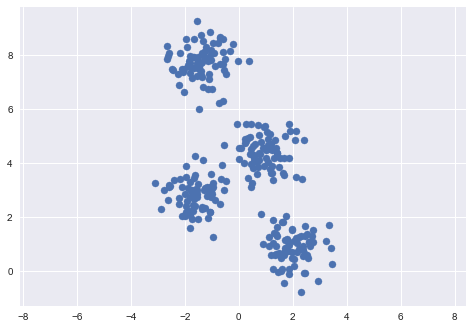

In [16]:
X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=0.60)

plt.scatter(X[:, 0], X[:, 1], s=50);
plt.axis('equal')
plt.show()

By eye, it is relatively easy to pick out the four clusters. If you were to perform an exhaustive search for the different segmentations of the data, however, the search space would be exponential in the number of points. Fortunately, the $K$-Means algorithm implemented in Scikit-learn provides a much more convenient solution.

<b>Exercise:</b>
    
The following frament of code runs the $K$-means method on the toy example you just created. Modify it, so that you can try other settings for the parameter options implemented by the method. In particular:

   - Reduce the number of runs to check the consequences of a bad initialization
   - Test different kinds of initializations (k-means++ vs random)
   - Provide a user-generated initialization that you consider can result in very suboptimal performance
   - Test other selections of the number of parameters
   - Include in the plot the location of the cluster of each class

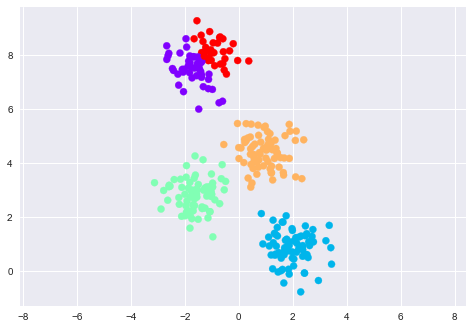

In [20]:
est = KMeans(5)  # 4 clusters
est.fit(X)
y_kmeans = est.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='rainbow');
plt.axis('equal')
plt.show()

### 2.3. The K-Means Algorithm: Interactive visualization

The following fragment of code allows you to study the evolution of cluster centroids on one run of the algorithm, and to modify also the number of centroids.


<function fig_code.figures.plot_kmeans_interactive.<locals>._kmeans_step>

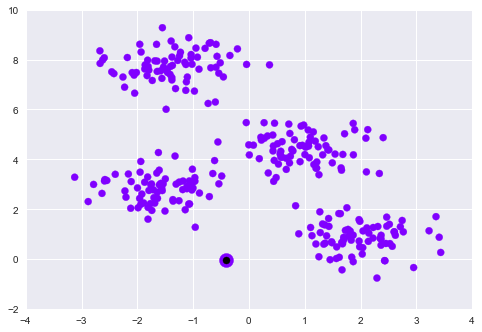

In [21]:
# This command may fail (interactivity not working properly) depending on the python version.
plot_kmeans_interactive()

### 2.4. Determining the number of clusters

If the number of clusters, $K$, is not known, selecting the appropriate value becomes a major issue. Since the overal distortion $D$ decreases with $K$, the selection of the number o clusters cannot be based on the overal distorsion. 

The best value of $K$ may be application dependent. Though we will not discuss specific algorithms in detail, we point out some possible solutions:

* Introduce a penalization functions: instead of minimizing $D$, we can traiing the clustering algorithm in order to minimize the funcional $D' = D + \lambda f(K)$, where $f$ is an increasing function penalizing large values of $K$, and $\lambda$ is an hyperparameter. For instance, we can take $f(K)=\log(K)$, $f(K)=K$, $f(K)=K^2$, etc.
* Select the value of $K$ minimizing some cluster-based metrics, like
    * the average <a href=http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score>silohuete coefficient</a>. The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b).
    * the <a href= http://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabaz_score.html#sklearn.metrics.calinski_harabaz_score> Calinski-Harabaz score </a>.


<b>Exercise:</b> Select the number of samples using any of the above metrics for the dataset in the previous examples.
    


## 3. Application of KMeans to Digits

For a closer-to-real-world example, let us take a look at a digit recognition dataset. Here we'll use KMeans to automatically cluster the data in 64 dimensions, and then look at the cluster centers to see what the algorithm has found.

In [25]:
digits = load_digits()

print('Input data and label number are provided in the following two variables:')
print("digits['images']: {0}".format(digits['images'].shape))
print("digits['target']: {0}".format(digits['target'].shape))

Input data and label number are provided in the following two variables:
digits['images']: (1797, 8, 8)
digits['target']: (1797,)


Next, we cluster the data into 10 groups, and plot the representatives (centroids of each group).  As with the toy example, you could modify the initialization settings to study the impact of initialization in the performance of the method


In [26]:
est = KMeans(n_clusters=10)
clusters = est.fit_predict(digits.data)
est.cluster_centers_.shape

(10, 64)

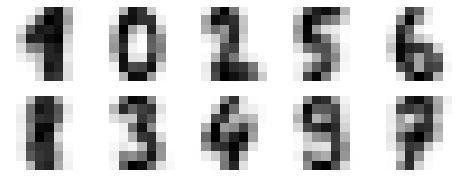

In [27]:
fig = plt.figure(figsize=(8, 3))
for i in range(10):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.imshow(est.cluster_centers_[i].reshape((8, 8)), cmap=plt.cm.binary)

We see that *even without the labels*, KMeans is able to find clusters whose means are recognizable digits (with apologies to the number 8)!

### 3.1. Visualization via Dimensionality Reduction

The following fragment of code projects the data into the two "most representative" dimensions, so that we can somehow visualize the result of the clustering (note that we can not visualize the data in the original 64 dimensions). In order to do so, we use a method known as Principal Component Analysis (PCA). This is a method that allows you to obtain a 2-D representation of multidimensional data: we extract the two most relevant features (using PCA) and look at the true cluster labels and $K$-means cluster labels:

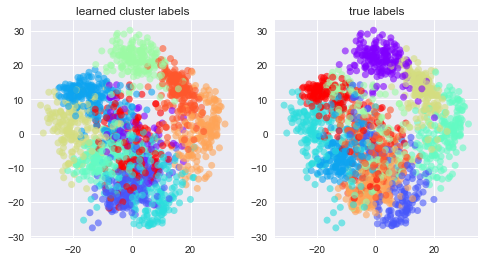

In [8]:
X = PCA(2).fit_transform(digits.data)

kwargs = dict(cmap = plt.cm.get_cmap('rainbow', 10),
              edgecolor='none', alpha=0.6)
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].scatter(X[:, 0], X[:, 1], c=est.labels_, **kwargs)
ax[0].set_title('learned cluster labels')

ax[1].scatter(X[:, 0], X[:, 1], c=digits.target, **kwargs)
ax[1].set_title('true labels');

### 3.2. Classification performance

Just for kicks, let us see how accurate our K-Means classifier is **with no label information**. In order to do so, we can work on the confussion matrix:

[[  0 177   0   0   0   0   0   1   0   0]
 [ 55   0  24   1   2  99   1   0   0   0]
 [  2   1 148   0   0   8  13   0   2   3]
 [  0   0   0   2   0   7 154   0  13   7]
 [  5   0   0   0   0   3   0 164   0   9]
 [  0   0   0 136   1   0   0   2  43   0]
 [  1   1   0   0 177   2   0   0   0   0]
 [  2   0   0   1   0   2   0   0   0 174]
 [  6   0   3   4   2 100   2   0  52   5]
 [ 20   0   0   6   0   2   6   0 139   7]]
Percentage of patterns that would be correctly classified: 81.69170840289371


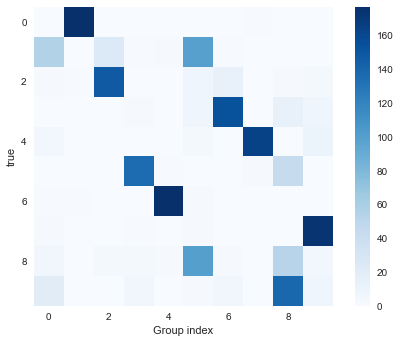

In [28]:
conf = confusion_matrix(digits.target, est.labels_)
print(conf)

plt.imshow(conf, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('Group index');

#And compute the number of right guesses if each identified group were assigned to the right class
print('Percentage of patterns that would be correctly classified: {0}'.format(
      np.sum(np.max(conf,axis=1)) * 100. / np.sum(conf)))

This is above 80% classification accuracy for an **entirely unsupervised estimator** which knew nothing about the labels.

## 4. Example: KMeans for Color Compression

One interesting application of clustering is in color image compression. For example, imagine you have an image with millions of colors. In most images, a large number of the colors will be unused, and conversely a large number of pixels will have similar or identical colors.

Scikit-learn has a number of images that you can play with, accessed through the datasets module. For example:

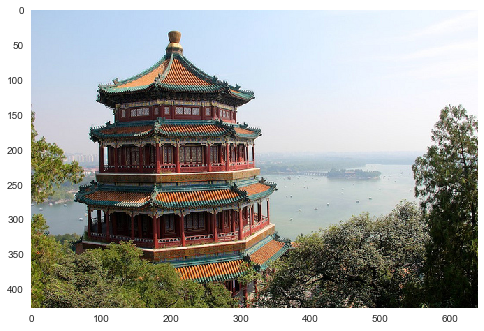

In [10]:
china = load_sample_image("china.jpg")
plt.imshow(china)
plt.grid(False);

The image itself is stored in a 3-dimensional array, of size ``(height, width, RGB)``. For each pixel three values are necessary, each in the range 0 to 255. This means that each pixel is stored using 24 bits.

In [29]:
print('The image dimensions are {0}'.format(china.shape))
print('The RGB values of pixel 2 x 2 are '.format(china[2,2,:]))

The image dimensions are (427, 640, 3)
The RGB values of pixel 2 x 2 are 


We can envision this image as a cloud of points in a 3-dimensional color space. We'll rescale the colors so they lie between 0 and 1, then reshape the array to be a typical scikit-learn input:

In [30]:
X = (china / 255.0).reshape(-1, 3)
print(X.shape)

(273280, 3)


We now have 273,280 points in 3 dimensions.

Our task is to use KMeans to compress the $256^3$ colors into a smaller number (say, 64 colors). Basically, we want to find $N_{color}$ clusters in the data, and create a new image where the true input color is replaced by the color of the closest cluster. Compressing data in this way, each pixel will be represented using only 6 bits (**25 % of the original image size**)

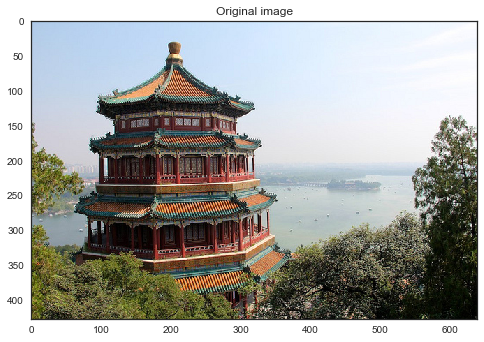

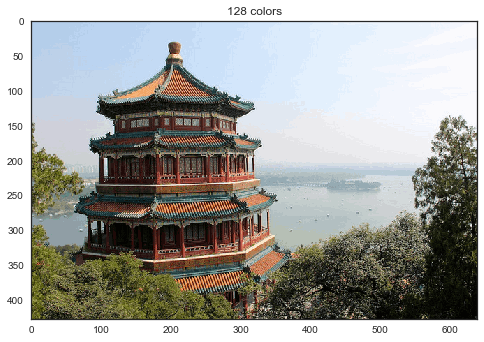

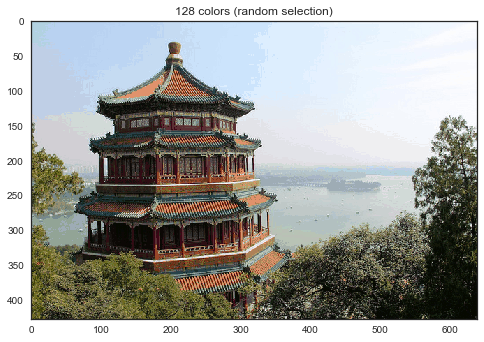

In [32]:
# reduce the size of the image for speed. Only for the K-means algorithm
image = china[::3, ::3]
n_colors = 128

X = (image / 255.0).reshape(-1, 3)
    
model = KMeans(n_colors)
model.fit(X)
labels = model.predict((china / 255.0).reshape(-1, 3))
#print labels.shape
colors = model.cluster_centers_
new_image = colors[labels].reshape(china.shape)
new_image = (255 * new_image).astype(np.uint8)

#For comparison purposes, we pick 64 colors at random
perm = np.random.permutation(range(X.shape[0]))[:n_colors]
colors = X[perm,:]

labels = np.argmin(cdist((china / 255.0).reshape(-1, 3),colors),axis=1)
new_image_rnd = colors[labels].reshape(china.shape)
new_image_rnd = (255 * new_image_rnd).astype(np.uint8)

# create and plot the new image
with sns.axes_style('white'):
    plt.figure()
    plt.imshow(china)
    plt.title('Original image')

    plt.figure()
    plt.imshow(new_image)
    plt.title('{0} colors'.format(n_colors))
    
    plt.figure()
    plt.imshow(new_image_rnd)
    plt.title('{0} colors'.format(n_colors) + ' (random selection)')
    

Compare the input and output image: we've reduced the $256^3$ colors to just 64. An additional image is created by selecting 64 colors at random from the original image. Try reducing the number of colors to 32, 16, 8, and compare the images in these cases.